# Exploration of the most mentioned USERS and BRANDS during NYFW

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder

from datetime import timedelta as td
from datetime import datetime

import seaborn as sns
sns.set(style='white', color_codes=True)
sns.set_context(rc={"font.family":"sans","font.size":24,"axes.titlesize":24,"axes.labelsize":24})

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn import datasets

Let's start by importing the dataset containing the information about the user mentions

In [2]:
path = 'Twitter_Bins/Hashtags_Bin/NYFW_06-18/NYFW_user-mention.csv'
dataset = pd.read_csv(path, encoding='utf-8', delimiter=';')

In [3]:
dataset.head()

,date,user,mentions,tweets
0,06/02/20,007phiranat,0,1.0
1,06/02/20,01firstsecond,5,1.0
2,06/02/20,01yellowmonkey,0,1.0
3,06/02/20,021716rs,0,1.0
4,06/02/20,0315lisamarie,0,1.0


We fill in all the missing values, adding zeros in tweets and mentions where missing

In [4]:
users = dataset.user.unique()

dataset['date'] = pd.to_datetime(dataset['date'])
#print(dataset['date'])

le = LabelEncoder()
le.fit(dataset['date'])
dataset['date'] = le.transform(dataset['date'])
datelist = dataset['date'].unique()

Reindexing the dataframe by date and user, in order to have zeros in teh days where the user didn't receive any mention or didn't tweet anything. 

In [5]:
user_mention = dataset.set_index(['user','date']) #.reindex(pd.date_range(min(user_mention['date']), max(user_mention['date']), freq="D"))

new_index = np.array(np.meshgrid(users,datelist)).T.reshape(-1,2)


user_mention = user_mention.reindex(new_index, fill_value=0).reset_index()
user_mention.date = le.inverse_transform(user_mention.date)
user_mention.date = pd.to_datetime(user_mention.date)

user_mention.head()

,user,date,mentions,tweets
0,007phiranat,2020-06-02,0,1.0
1,007phiranat,2020-07-02,0,0.0
2,007phiranat,2020-08-02,0,0.0
3,007phiranat,2020-09-02,0,0.0
4,007phiranat,2020-10-02,0,0.0


In [6]:
user_mention.describe()

,mentions,tweets
count,2.495207e+06,2.495205e+06
mean,2.225795e-01,1.842125e-01
std,2.506601e+01,1.308000e+00
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.422200e+04,3.760000e+02


We can see that most of the users received zero mentions during one day. Let's see how the mentions are distributed when we compute the sum of all received mentions for every user.

In [7]:
aggregated_mentions = user_mention.groupby('user').sum().sort_values('mentions',ascending = True).reset_index()
aggregated_mentions.describe()

,mentions,tweets
count,191939.000000,191939.000000
mean,2.893534,2.394761
std,254.849498,13.804154
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,2.000000
max,102154.000000,3593.000000


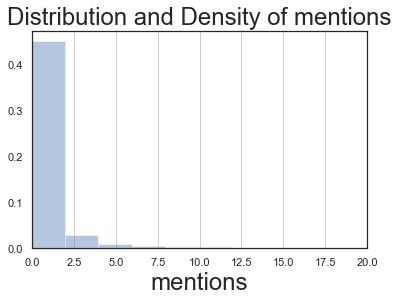

In [8]:
hist2 = sns.distplot(aggregated_mentions[aggregated_mentions['mentions']<100]['mentions'])
hist2.set_title('Distribution and Density of mentions')
plt.xlim(left=0,right=20)
plt.grid(axis='x')

In [9]:
aggregated_mentions = aggregated_mentions.sort_values('mentions', ascending=False)

As we can see most users weren't even mentioned most of the time. So we can shrink the dataset a lot, by getting rid of those users who havent been mentioned at least 20 times, which can be considered as a reasonable amount of mentions, in order to be relevant for our analysis. 

### Let's select only those users who have had at least 20 mentions throughout the whole week

First of all let's sum the mentions of the different users across the different days taken into account, then we filter out those who haven't had at least 20 mentions.

In [10]:
more_than_20 = aggregated_mentions['mentions'] > 20
most_mentioned = aggregated_mentions[more_than_20]
#Essendo raggruppati per user, user sarebbe l'indice, azzero l'indice e lo metto in una colonna
most_mentioned = most_mentioned.reset_index()
most_mentioned

,index,user,mentions,tweets
0,191938,poshmarkapp,102154,0.0
1,191937,originalfunko,24885,2.0
2,191936,coach,22822,87.0
3,191935,michaelkors,13808,62.0
4,191934,loungefly,12455,0.0
...,...,...,...,...
1755,190248,_hinakhanteam,21,0.0
1756,190249,mango,21,0.0
1757,190250,marica_1029,21,7.0
1758,190251,modernnotoriety,21,1.0


## We select the users corresponding to the brands that exhibited during the nyfw

In [11]:
ny_brands = pd.read_csv('./NYFW.csv', sep=';')
#convert all usernames into lowercase
ny_brands.dropna(subset=['Twitter'], inplace=True)
ny_brands['Twitter'] = ny_brands['Twitter'].str.lower()
ny_brands['Day'] = ny_brands['Day'].apply(str)
ny_brands['Day'] = ny_brands['Day'].apply(lambda s : s.split('-')[0])
ny_brands.notna()['Day'] = ny_brands['Day'].apply(int)
ny_brands

,Num,Brand,Day,Hour,Location,Instagram,Twitter
1,2.0,TOM FORD,07,NaN,Los Angeles,tomford,tomford
2,3.0,RAG & BONE,07,7:00 PM,Skylight Vesey,ragandbone,rag_bone
4,5.0,BRANDON MAXWELL,08,8:00 PM,American Museum of Natural History,brandonmaxwell,brandonmaxwell
5,6.0,BADGLEY MISCHKA,08,10:00 AM,Spring Studios,badgleymischka,badgleymischka
9,10.0,SNOW XUE GAO,08,by appointment,NaN,snowxuegao,snowxuegao
10,11.0,TIBI,08,by appointment,NaN,tibi,tibi
11,12.0,ADAM LIPPES,08,9:00 AM,NaN,adamlippes,adamlippes
12,13.0,SELF-PORTRAIT,08,10:00 AM,NaN,mrselfportrait,_selfportrait_
14,15.0,LONGCHAMP,08,1:00 PM,NaN,longchamp,longchamp
15,16.0,REBECCA MINKOFF,08,2:00 PM-4:00 PM,NaN,rebeccaminkoff,rebeccaminkoff


In [12]:
#select users that exhibited during the fashion week
nyfw_most_mentioned = most_mentioned[most_mentioned['user'].isin(ny_brands['Twitter'])]
nyfw_mention = user_mention[user_mention['user'].isin(ny_brands['Twitter'])]
nyfw_mention = nyfw_mention[nyfw_mention['user'].isin(nyfw_most_mentioned['user'])]
nyfw_mention.head(15)

,user,date,mentions,tweets
8125,aliceandolivia,2020-06-02,112,0.0
8126,aliceandolivia,2020-07-02,74,0.0
8127,aliceandolivia,2020-08-02,14,0.0
8128,aliceandolivia,2020-09-02,4,0.0
8129,aliceandolivia,2020-10-02,11,0.0
8130,aliceandolivia,2020-11-02,486,0.0
8131,aliceandolivia,2020-12-02,81,0.0
8132,aliceandolivia,2020-02-13,13,0.0
8133,aliceandolivia,2020-02-14,12,0.0
8134,aliceandolivia,2020-02-15,4,0.0


Let's plot the cumulative mentions for each brand during the whole FW.

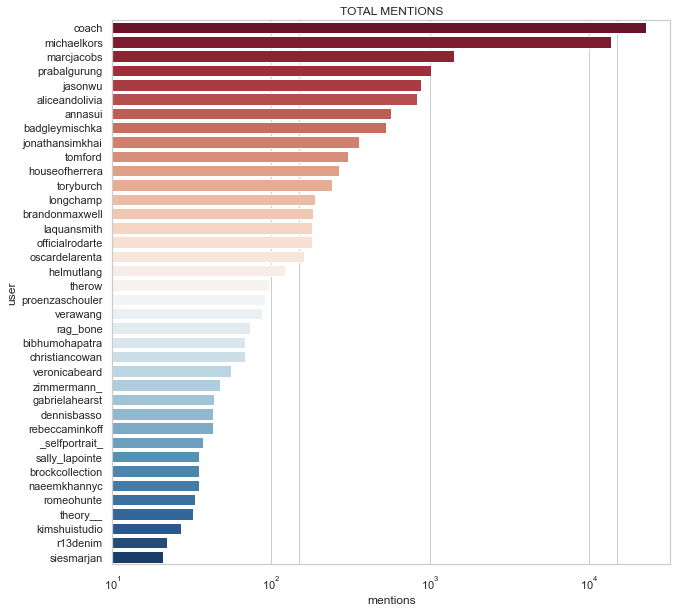

In [13]:
from numpy import median, var

plt.figure(figsize=(10,10))
sns.set(style='whitegrid')
g = sns.barplot(x="mentions", y='user', palette='RdBu', estimator=np.sum,
                ci=None, order=nyfw_most_mentioned['user'], data=nyfw_mention)
g.set_xscale('log')
plt.xticks(np.array([10,100,150,1000,10000,15000]))
plt.title('TOTAL MENTIONS')
plt.savefig("total_mentions_log.png")

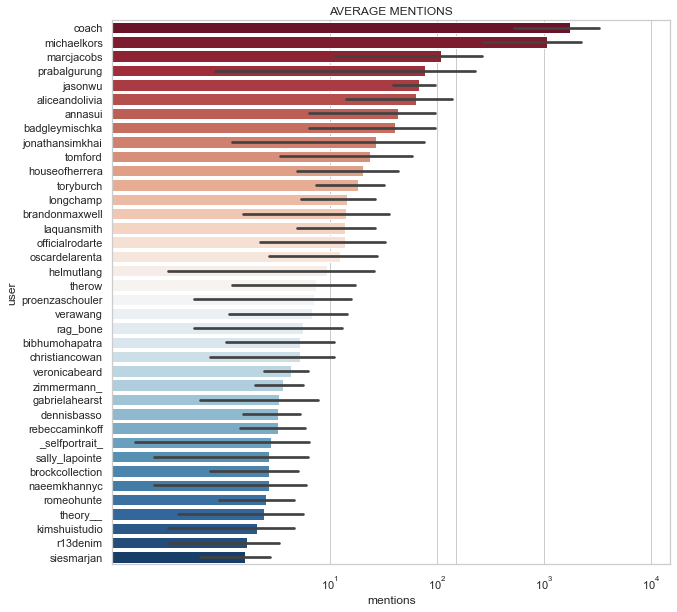

In [14]:
plt.figure(figsize=(10,10))
sns.set(style='whitegrid')
g = sns.barplot(x="mentions", y='user', palette='RdBu', estimator=np.mean,
                order=nyfw_most_mentioned['user'], data=nyfw_mention)
g.set_xscale('log')
plt.xticks(np.array([10,100,150,1000,10000,15000]))
plt.title('AVERAGE MENTIONS')
plt.savefig('avg_mentions_log.png')